  
# Trabajo Práctico 1

## Simulación de Eventos Discretos

#### Departamento de Computación - Facultad de Ciencias Exactas y Naturales - Universidad de Buenos Aires

20 de Septiembre de 2021

**Grupo 04:** Confalonieri, Gisela - Lucero, Emiliano
    

----

# Modelo conceptual

En el presente trabajo modelaremos un **sistema de evaluación de un centro de atención telefónica de una entidad bancaria**. 

Una **simplificación** de este tipo de sistemas podría ser la siguiente:

* Una persona llama a la central telefónica de la entidad bancaria.
* Una contestadora automática solicita datos a la persona para derivarla al área correspondiente a su solicitud.
* El llamado es colocado en espera para ser atendido por un agente del área correspondiente.
* El agente atiende la llamada y resuelve la solicitud.
* Durante el recorrido de la llamada a través del sistema, se recopilan datos que serán utilizados en la generación de métricas de calidad de servicio.

El objetivo de nuestro modelo es **comparar posibles configuraciones en cuanto a la disposición de los agentes en cada una de las áreas de atención, para evaluar los cambios de performance (tiempo de demora en resolver una solicitud) según las métricas obtenidas**. Las posteriores simulaciones permitirían **analizar distintos escenarios en los que se observen mejoras en el servicio.**

## Estructura del modelo

Nuestro modelo comprenderá:

* Un **generador de las llamadas** que ingresan al centro de atención
* Una **mesa de entrada** que redirigirá las llamadas al área correspondiente
* Dos **áreas de atención específicas**, una para clientes y otra para no clientes
* Un **medidor de métricas de calidad**

Por lo tanto, un primer bosquejo de la estructura de nuestro modelo comprende los siguientes componentes:

### **Esquema conceptual general del modelo**

![esquema general](https://raw.githubusercontent.com/giselabelen/SED2021/master/imgs/SED2021-TP1-General.png)

A continuación presentaremos cada componente del sistema, con una descripción breve, un esquema conceptual, y su especificación formal DEVS.

### Generador de llamadas

* Representa las llamadas que recibe el centro de atención.
* Su único input corresponde a un evento que indica cuándo dejar de generar llamados.
* Periódicamente genera llamadas según alguna distribución.
* Cada llamada generada corresponde a un cliente o a una persona que aún no es cliente.

#### **Esquema conceptual del generador de llamadas**
  
![esquema generador](https://raw.githubusercontent.com/giselabelen/SED2021/master/imgs/SED2021-TP1-Generador.png)

#### **Especificación formal del generador de llamadas**

$ generadorDeLlamadas = <X,Y,S,\delta_{int},\delta_{ext},\lambda,ta> $

$X = \{parar\}$

$Y = \{llamada\}$

$S = \{generando,parado\}$

$\delta_{int}(generando) = generando$

$\delta_{ext}(generando,e,parar) = parado$

$\lambda(generando) =$ 
```c++
id <- número entero identificatorio //único para cada llamada generada en una simulación
es_cliente <- booleano aleatorio //true si es llamada de cliente, false para no cliente
enviar como output la tupla <id,es_cliente> //esta tupla representa la llamada
```

$ta(generando) = $ ```valor aleatorio según distirbuciónLlamada```

$ta(parado) = inf$

#### **Representación de estados y transiciones del generador de llamadas**
  
![estados_generador](./imgs/generador_estados.png)

### Mesa de entrada

* Recibe las llamadas como input, y las redirige al área correspondiente.
  * Las llamadas ingresan a una cola de espera.
  * Un subcomponente va desencolando las llamadas y enviándolas al área correspondiente.

#### **Esquema conceptual de la mesa de entrada**
  
![esquema mesa](https://raw.githubusercontent.com/giselabelen/SED2021/master/imgs/SED2021-TP1-mesa_de_entrada.png)

#### **Especificación formal de la mesa de entrada y sus subcomponentes**

##### **Cola**

$Cola = <X,Y,S,\delta_{int},\delta_{ext},\lambda,ta>$

$X = \{entrada, liberar\}$

$Y = \{salida\}$

$S = \{estado \in \{encolando,vacia,liberando\},llamadasEncoladas,sigEstado,hayPedido\}$

$\delta_{int}((liberando,llE,0,hayP)) = (vacia,llE,0,hayP)$

$\delta_{int}((liberando,llE,1,hayP)) = (encolando,llE,1,hayP)$

$\delta_{ext}(s,e,x) =$

```c++
case port:
    entrada:
        s.llamadasEncoladas.push(x) //agrego la nueva llamada a la cola
        if s.hayPedido // si tengo un pedido esperando le doy esta llamada
            pasar a (liberando,s.llamadasEncoladas,s.sigEstado,false)
        else // si no me pidieron nada sigo encolando
            pasar a (encolando,s.llamadasEncoladas,s.sigEstado,s.hayPedido)
    liberar:
        if s.estado == encolando
            pasar a (liberando,s.llamadasEncoladas,s.sigEstado,s.hayPedido)
        if s.estado == vacia //no tengo llamadas asi que anoto para cuando entre una
            s.hayPedido <- true
```

$\lambda((liberando,llE,sigE,hayP)) =$

```c++
llam = llE.pop
if llE.empty
    sigE <- 0 // si es la ultima llamada encolada, luego me voy a vacia
else
    sigE <- 1 // si todavia hay mas llamadas, luego me voy a encolando
enviar llam por salida
```

$ta(encolando) = inf$

$ta(vacia) = inf$

$ta(liberando) = 0$

#### **Representación de estados y transiciones del generador de llamadas**
  
![estados_cola](./imgs/Cola.png)

##### **Distribuidor de llamadas**

$ Distribuidor Llamadas = <X,Y,S,\delta_{int},\delta_{ext},\lambda,ta> $

$X = \{entrante\}$

$Y = \{pedirLlamada, clientes, noClientes\}$

$S = \{pidiendo, esperando, enviando, llamada\}$

$\delta_{int}(pidiendo) = esperando$

$\delta_{int}(enviando) = pidiendo$

$\delta_{ext}(esperando, e, entrante) = enviando$

$\lambda(s) =$ 
```c++
case s:
    pidiendo:
        enviar 1 por pedirLlamada
    enviando:
        // Recibi una llamada de la cola
        if es llamada de cliente
            enviar llamada por clientes
        else
            enviar llamada por noClientes
    otherwise:
        error   
```

$ta(esperando) = inf$

$ta(pidiendo) = 0$

$ta(enviando) =$ ```valor de retardo aleatorio```

**Representación de estados y transiciones del generador de llamadas**
  
![estados_generador](./imgs/mesadeentrada_estados.png)

##### **Mesa de entrada**

$ Mesa De Entrada = <X,Y, \{Cola, DistribuidorLlamadas\},EIC,EOC,IC,Select> $

$X = \{entrante\}$

$Y = \{llamadaCliente, llamadaNoCliente\}$

$EIC = \{(MesaDeEntrada.entrante, Cola.entrada)\}$

$EOC = \{ 
         (DistribuidorLlamadas.clientes, MesaDeEntrada.llamadaCliente),\\
         (DistribuidorLlamadas.noClientes, MesaDeEntrada.llamadaNoCliente)\}$

$IC = \{
        (Cola.salida, DistribuidorLlamadas.entrante),\\
        (DistribuidorLlamadas.pedirLLamada, Cola.liberar)\}$

$Select = \{ Cola, DistribuidorLlamadas \}$

 ### Áreas de atención específica

* Cada una de las áreas recibe como input las llamadas que llegan desde la mesa de entrada.
* Estas llamadas ingresan a una cola de espera.
* Un distrbuidor va desencolando las llamadas y asignándolas a los agentes que se encuentren disponibles.
* Cada agente atiende una llamada y resuelve la solicitud. 
* Cada área comunica, a través de sus outputs, el momento en que cada llamada es atendida por un agente y el momento en que cada agente resuelve la solicitud de una llamada y la misma finaliza.

#### **Esquema conceptual de las áreas de atención específica**
  
![esquema areas](https://raw.githubusercontent.com/giselabelen/SED2021/master/imgs/SED2021-TP1-areas_especificas.png)

#### **Especificación formal del área de atención y sus subcomponentes**

##### **Distribuidor agentes**

$ Distribuidor Agentes = <X,Y,S,\delta_{int},\delta_{ext},\lambda,ta> $

$X = \{pedido, entrante\}$

$Y = \{pedirLlamada, agente1, agente2\}$

$S = \{estado\in\{desocupado, pidiendo, esperando, enviando\},pedidosEnEspera,luegoDeEnviar\}$

$\delta_{int}((pidiendo,p,l))= (esperando,p,l)$

$\delta_{int}((enviando,p,0)) = (desocupado,p,0)$

$\delta_{int}((enviando,p,1)) = (pidiendo,p,1)$

$\delta_{ext}(s,e,x) =$

```c++
case s.estado:
    desocupado:
        if x == pedido
            s.pedidosEnEspera.push(x) //agrego el pedido a los pedidos en espera
            pasar a (pidiendo,s.pedidosEnEspera,s.luegoDeEnviar)
    esperando:
        if x == entrante
            pasar a (pidiendo,s.pedidosEnEspera,s.luegoDeEnviar)
```

$\lambda(s) =$ 

```c++
case s.estado:
    pidiendo:
        enviar 1 por pedirLlamada
    enviando:
        // Recibi una llamada de la cola
        desencolar s.pedidosEnEspera
        enviar llamada por puerto correspondiente al pedido desencolado
        if s.pedidosEnEspera.emtpy //si ya no hay pedidos encolados
            luegoDeEnviar = 0 // proximo estado desocupado
        else 
            luegoDeEnviar = 1 // proximo estado pidiendo
    otherwise:
        error
```

$ta(desocupado,p,l) = inf$

$ta(pidiendo,p,l) = 0$

$ta(esperando,p,l) = inf$

$ta(enviando,p,l) = 0$

**Representación de estados y transiciones del distribuidor a agentes**
  
![estados_distribuidoragentes](./imgs/distribuidoragentes_estados.png)

##### **Agente**

$ Agente = <X,Y,S,\delta_{int},\delta_{ext},\lambda,ta> $

$X = \{entrante\}$

$Y = \{pedido, finalizada\}$

$S = \{estado \in \{atendiendo, pidiendo\}, T, llamada,id\}$

$\delta_{int}((atendiendo,t,l,i)) = (pidiendo,t,l,i)$

$\delta_{ext}((pidiendo,t,l,id), e, x) =$ 

``` C++
T <- valor aleatorio dado por la distribución elegida
pasar a (atendiendo,T,x,id) //x es la llamada entrante
```

$\lambda((atendiendo,t,llam,id) =$ 

``` C++
// Estaba atendiendo y ya transcurrió ta, por lo que terminé de atender la llamada
// La libero y aviso que estoy libre, pidiendo que me pasen otra llamada
enviar llam por finalizada
enviar id por pedido
```

$ta((pidiendo,t,l,i)) = inf $

$ta((atendiendo,t,l,i)) = t$


**Representación de estados y transiciones del agente**

![estados_agente](./imgs/agente_estados.png)

##### **Area de atención**

$ AreaAtencion = <X,Y, \{Cola, DistribuidorAgentes, Agente1, Agente2\},EIC,EOC,IC,Select> $

$X = \{entrante\}$

$Y = \{llamadaAtendida, llamadaFinalizada\}$

$EIC = \{(AreaAtencion.entrante, Cola.entrada)\}$

$EOC = \{ 
        (DistribuidorAgentes.agente1, AreaAtencion.llamadaAtendida),\\
        (DistribuidorAgentes.agente2, AreaAtencion.llamadaAtendida),\\
        (Agente1.finalizada, AreaAtencion.llamadaFinalizada),\\
        (Agente2.finalizada, AreaAtencion.llamadaFinalizada)
        \}$

$IC = \{
        (Cola.salida, DistribuidorAgentes.entrante),\\
        (DistribuidorAgentes.pedirLLamada, Cola.liberar),\\
        (DistribuidorAgentes.agente1, Agente1.entrante),\\
        (DistribuidorAgentes.agente2, Agente2.entrante),\\
        (Agente1.pedido, DistribuidorAgentes.pedido),\\
        (Agente2.pedido, DistribuidorAgentes.pedido)
        \}$

$Select = \{ Cola, DistribuidorAgentes, Agente1, Agente2 \}$

### Medidor de métricas

* Comprende diversos subcomponentes que evaluarán distintas métricas de calidad cada uno, a partir de los datos recibidos a lo largo del recorrido de la llamada por el centro de atención telefónica, a saber:
  * Momento en que arriba una llamada al servicio
  * Momento en que la llamada es atendida por un agente
  * Momento en que la solicitud es resuelta por un agente
* Nuestro primer bosquejo comprende las siguientes métricas:
  * Tiempo promedio que una llamada está aguardando ser atendida (es decir, desde que llega hasta que es atendida por un agente)
  * Tiempo máximo que una llamada estuvo aguardando ser atendida (es decir, desde que llega hasta que es atendida por un agente)
  * Tiempo promedio que una llamada consume dentro del centro de atención (es decir, desde que llega hasta que su solicitud se resuelve)
  * Tiempo máximo que una llamada consumió dentro del centro de atención (es decir, desde que llega hasta que su solicitud se resuelve)

#### **Esquema conceptual del medidor**
  
![esquema medidor](https://raw.githubusercontent.com/giselabelen/SED2021/master/imgs/SED2021-TP1-Medidor.png)

#### **Especificación formal del medidor**

$ Medidor = <X,Y,S,\delta_{int},\delta_{ext},\lambda,ta> $

$X = \{entrante, atendida, finalizada\}$

$Y = \{mediciones\}$

$S = \{midiendo, tiempoInicial, tiempoRestante, entrantesXTiempo, atendidasXTiempo, finalizadasXTiempo\}$

$\delta_{int}((m,tI,tR,eXT,aXT,fXT)) = (m,tI,tI,[],[],[])$ ```reseteo las variables cada vez que vence ta```

$\delta_{ext}(s, e, x) =$ 

``` C++
case port: //actualizo los diccionarios
    entrante:
        s.entrantesXTiempo[x.id] <- <timestamp, x.esCliente>
    atendida:
        s.atendidasXTiempo[x.id] <- <timestamp, x.esCliente>
    finalizada:
        s.finalizadasXTiempo[x.id] <- <timestamp, x.esCliente>
    otherwise:
        Error

s.tiempoRestante <- s.tiempoRestante - e //actualizo tiempo para seguir con lo que restaba de ta inicial
pasar a s
```

$\lambda(s) =$ 
```c++
//tiempo promedio y maximo en atender llamada
tAtender <- 0
maxAtender <- 0
para cada id en s.atendidasXTiempo
    t <- s.atendidasXTiempo[id][timestamp] - s.entrantesXTiempo[id][timestamp]
    tAtender += t
    if maxAtender < t
        maxAtender <- t
promAtender <- tAtender/s.atendidasXTiempo.length

//tiempo promedio y maximo en resolver llamada
tFin <- 0
maxFin <- 0
para cada id en s.finalizadasXTiempo
    t <- s.finalizadasXTiempo[id][timestamp] - s.entrantesXTiempo[id][timestamp]
    tFin += t
    if maxFin < t
        maxFin <- t
promFin <- tFin/s.finalizadasXTiempo.length

//armo la tupla para output
m = <promAtender,maxAtender,promFin,maxFin>
enviar m por mediciones
```

$ta(s) = s.tiempoRestante$

Luego de haber especificado detalladamente cada componente del sistema, presentamos a continuación la especificación DEVS del acoplado final.

#### **Especificación formal del centro de atención telefónica**

$ CentroAtencion$ = $<X,Y, \{GeneradorLlamadas, MesaDeEntrada, AreaClientes, AreaNoClientes, Medidor\},EIC,EOC,IC,Select>$

$X = \{parar\}$

$Y = \{metricas\}$

$EIC = \{ (CentroAtencion.parar, GeneradorLlamadas.parar) \}$

$EOC$ = $\{ (Medidor.medicion, CentroAtencion.metricas)\}$

$IC$ = $\{
        (GeneradorLLamadas.llamada, MesaDeEntrada.entrante),\\
        (GeneradorLLamadas.llamada, Medidor.entrante),\\
        (MesaDeEntrada.clientes, AreaClientes.entrante),\\
        (MesaDeEntrada.noClientes, AreaNoClientes.entrante),\\
        (AreaClientes.atendida, Medidor.atendida),\\
        (AreaClientes.finalizada, Medidor.finalizada),\\
        (AreaNoClientes.atendida, Medidor.atendida),\\
        (AreaNoClientes.finalizada, Medidor.finalizada),\\
        \}$

$Select = \{ GeneradorLlamadas, MesaDeEntrada, AreaClientes, AreaNoClientes, Medidor \}$

# Simulación

Preparamos el entorno

In [1]:
from pathlib import Path

SED_HOME = Path.home().joinpath('SED')

#Directorio base donde está instalado el siumulador
CDPP_DIR = SED_HOME.joinpath('CDPP_ExtendedStates-codename-Santi')

CDPP_SRC = CDPP_DIR.joinpath('src')
CDPP_EXAMPLES = CDPP_DIR.joinpath('examples')
CDPP_SCRIPTS = CDPP_DIR.joinpath('scripts')
BASE_BIN = CDPP_SRC.joinpath('bin')
CDPP_ATOMICS = CDPP_SRC.joinpath('cd++/atomics')

Copiamos los archivos del modelo a la carpeta examples de CD++

In [79]:
%%bash -s "$CDPP_EXAMPLES"

cp -r TP1-CentroAtencion $1/

Compilamos el simulador

In [4]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/TP1-CentroAtencion/src

# make clean

# Correr para compilar viendo cada paso
make -j4


make -C ../../../src/cd++ cd++ OUT_DIR=/home/gisela/SED/CDPP_ExtendedStates-codename-Santi/examples/TP1-CentroAtencion/src/bin MODEL_FLAGS=-DREGISTER_ATOMICS
make[1]: se entra en el directorio '/home/gisela/SED/CDPP_ExtendedStates-codename-Santi/src/cd++'
make -C /home/gisela/SED/CDPP_ExtendedStates-codename-Santi/src/cd++/atomics OBJ_DIR=obj SRC_DIR=/home/gisela/SED/CDPP_ExtendedStates-codename-Santi/src/cd++ MODEL_FLAGS=-DREGISTER_ATOMICS
make -C /home/gisela/SED/CDPP_ExtendedStates-codename-Santi/src/cd++/cell OBJ_DIR=obj SRC_DIR=/home/gisela/SED/CDPP_ExtendedStates-codename-Santi/src/cd++ MODEL_FLAGS=-DREGISTER_ATOMICS
make[2]: se entra en el directorio '/home/gisela/SED/CDPP_ExtendedStates-codename-Santi/src/cd++/atomics'
make -C cpu OBJ_DIR=obj SRC_DIR=/home/gisela/SED/CDPP_ExtendedStates-codename-Santi/src/cd++
make -C queue OBJ_DIR=obj SRC_DIR=/home/gisela/SED/CDPP_ExtendedStates-codename-Santi/src/cd++
make -C qss OBJ_DIR=obj SRC_DIR=/home/gisela/SED/CDPP_ExtendedStates-codena

/home/gisela/SED/CDPP_ExtendedStates-codename-Santi/examples/TP1-CentroAtencion/src/bin/libsimu.a(macroexp.o): En la función `macroExpansion::expand[abi:cxx11]()':
/home/gisela/SED/CDPP_ExtendedStates-codename-Santi/src/cd++/utils/macroexp.cpp:147: aviso: the use of `tmpnam' is dangerous, better use `mkstemp'
warped/notime/obj/DebugStream.o: En la función `DebugStream::interact()':
/home/gisela/SED/CDPP_ExtendedStates-codename-Santi/src/cd++/warped/notime/DebugStream.cpp:682: aviso: the `gets' function is dangerous and should not be used.


## Tests
### GeneradorLlamadas

Primero probamos generar las llamadas con distribución constante en el tiempo.

In [80]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/TP1-CentroAtencion/src/

bin/cd++ -m ../model/test_generador1.ma  \
         -e ../model/test_generador1.ev  \
         -l ../test_generador1.log \
         -o ../test_generador1.out

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from ../model/test_generador1.ma
Loading events from ../model/test_generador1.ev
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ../test_generador1.log
Output to: ../test_generador1.out
Tolerance set to: 1e-

Luego probamos con distribución de poisson con media=5.

In [81]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/TP1-CentroAtencion/src/

bin/cd++ -m ../model/test_generador2.ma  \
         -e ../model/test_generador2.ev  \
         -l ../test_generador2.log \
         -o ../test_generador2.out

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from ../model/test_generador2.ma
Loading events from ../model/test_generador2.ev
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ../test_generador2.log
Output to: ../test_generador2.out
Tolerance set to: 1e-

#### Análisis de los resultados de tests para el modelo GeneradorLlamadas

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# definimos los path a los archivos de interés
OUT_FILENAME = str(CDPP_EXAMPLES)+"/TP1-CentroAtencion/test_generador2.out"

# definimos los nombres de las columnas en los dataframes de pandas
TIME_COL = 'time'
PORT_COL = 'port'
VALUE_COL = 'value'
MESSAGE_TYPE_COL = 'message_type'
MODEL_ORIGIN_COL = 'model_origin'
MODEL_DEST_COL = 'model_dest'

# parsea cada fila del dataframe
def parse_value(value: str):
    is_list = value.strip().startswith("[") and value.strip().endswith("]")
    if is_list:
        return tuple(float(num) for num in value.replace('[', '').replace(']', '').split(', '))
    return float(value)

# conversion VTime a float
def time_to_secs(time):
    h, m, s, ms, r = time.split(':')
    return float(h)*60*60. + float(m)*60. + float(s) + float(ms)/1000. + float(r)/1000.

df_converters = {
    VALUE_COL: parse_value,
    TIME_COL: time_to_secs
}

salida = pd.read_csv(OUT_FILENAME,
                     delimiter=r'(?<!,)\s+',
                     engine='python',  # C engine doesnt work for regex
                     converters=df_converters,
                     names=[TIME_COL, PORT_COL, VALUE_COL]
                    )

# veamos cómo luce el dataframe con los datos de salida
salida.head() # filtro por índice

,time,port,value
0,0.0,out,"(0.0, 1.0)"
1,3.0,out,"(1.0, 1.0)"
2,6.0,out,"(2.0, 1.0)"
3,10.0,out,"(3.0, 0.0)"
4,17.0,out,"(4.0, 1.0)"


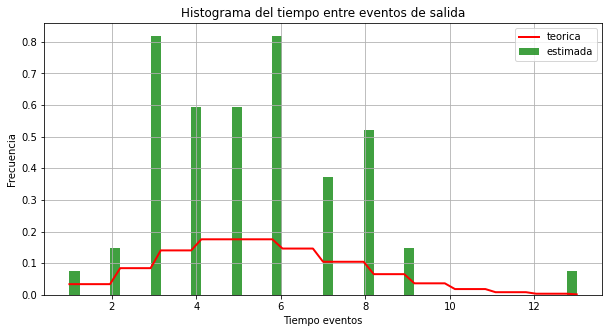

In [87]:
import scipy.stats as sps

# tiempo entre eventos de salida
x_values = np.diff(salida[TIME_COL])

plt.figure(figsize=(10,5))

# histograma de los eventos de salida
n, bins, patches = plt.hist(x_values, 50, density=True, facecolor='g', alpha=0.75,label='estimada')

# probability mass function
_mu=5
e = sps.poisson.pmf(bins.astype(int), _mu,loc=0)
plt.plot(bins,e,'r',linewidth=2,label='teorica')

plt.xlabel('Tiempo eventos')
plt.ylabel('Frecuencia')
plt.title('Histograma del tiempo entre eventos de salida')
plt.grid(True)
plt.legend();

## Experimentos

Corremos la simulacion con la disposición estandar

In [53]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/TP1-CentroAtencion/src/

bin/cd++ -m ../model/centro_atencion.ma  \
         -e ../model/centro_atencion.ev  \
         -l ../centro_atencion.log \
         -o ../centro_atencion.out

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from ../model/centro_atencion.ma
Loading events from ../model/centro_atencion.ev
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ../centro_atencion.log
Output to: ../centro_atencion.out
Tolerance set to: 1e-

Exception MException thrown!
Description: Data not found!!!
R(etry), I(gnore), P(anic)?
Thrown in: 
	File: ini.cpp - Method: definition - Line: 55
	File: GeneradorLlamadas.cpp - Method: GeneradorLlamadas - Line: 68
Description: 
	generador/distribution Not Found!
